In [1]:
import gdsfactory as gf
import sax 
import gplugins.sax as gs
import tidy3d as td
import gplugins
from gplugins.gmeep.get_simulation import get_simulation
import meep as mp

import gplugins.tidy3d as gt
import gplugins.gmeep as gm
from gdsfactory.generic_tech import LAYER_STACK, get_generic_pdk

import jax
import jax.example_libraries.optimizers as opt
import jax.numpy as jnp
import numpy as np
from tqdm.notebook import trange
import matplotlib.pyplot as plt
from gplugins.common.config import PATH
from gplugins import plot

2024-05-24 11:32:24.441 | INFO     | gplugins.gmeep:<module>:39 - Meep '1.28.0' installed at ['/home/doan/miniconda3/envs/mp/lib/python3.11/site-packages/meep']


2024-05-24 11:34:12.520 | INFO     | gplugins.tidy3d.modes:_data:265 - load data from /home/doan/.gdsfactory/modes/Waveguide_72ea6dfa0835095b.npz.
2.4394712000769285


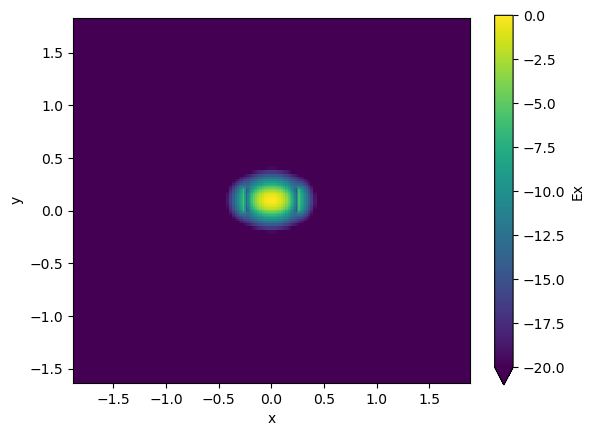

In [6]:
# STRAIGHT WAVEGUIDE MODE
strip = gt.modes.Waveguide(
    wavelength=1.55,
    core_width=0.5,
    core_thickness=0.2,
    slab_thickness=0.0,
    core_material="si",
    clad_material="sio2",
)
print(strip.n_eff.real[0])
strip.plot_field(field_name="Ex", mode_index=0, value="dB") 

2024-05-24 11:34:24.463 | WARNING  | gdsfactory.cross_section:validate_radius:223 - UserWarning: min_bend_radius 3 < CrossSection.radius_min 5.0. 
2024-05-24 11:34:24.478 | INFO     | gdsfactory.technology.layer_views:to_lyp:1018 - LayerViews written to '/tmp/gdsfactory/bend_euler_radius3.lyp'.


/home/doan/miniconda3/envs/mp/lib/python3.11/site-packages/gdsfactory/cross_section.py:223: UserWarning: min_bend_radius 3 < CrossSection.radius_min 5.0. 
  warnings.warn(message)


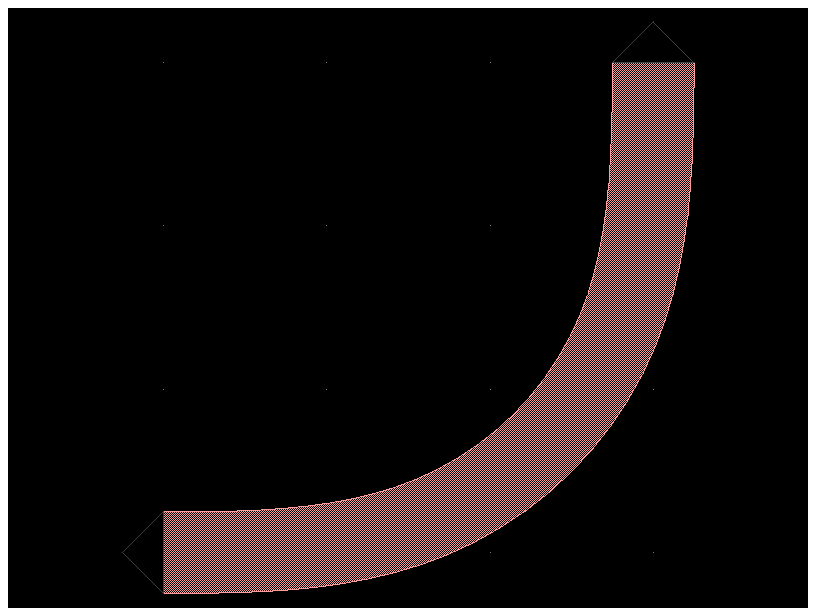

In [7]:
bend = gf.components.bend_euler(radius=3)
bend.plot()

core_material = gplugins.get_effective_indices(
    core_material=3.4777,
    clad_materialding=1.444,
    nsubstrate=1.444,
    thickness=0.2,
    wavelength=1.55,
    polarization="te",
)[0]

In [8]:
sp = gm.write_sparameters_meep(
    bend, 
    resolution= 20, 
    is_3d=False,
    material_name_to_meep = dict(si=core_material),
    filepath="data/bend.npz"
)

2024-05-24 11:34:28.490 | INFO     | gplugins.gmeep.write_sparameters_meep:write_sparameters_meep:396 - Simulation loaded from PosixPath('data/bend.npz')


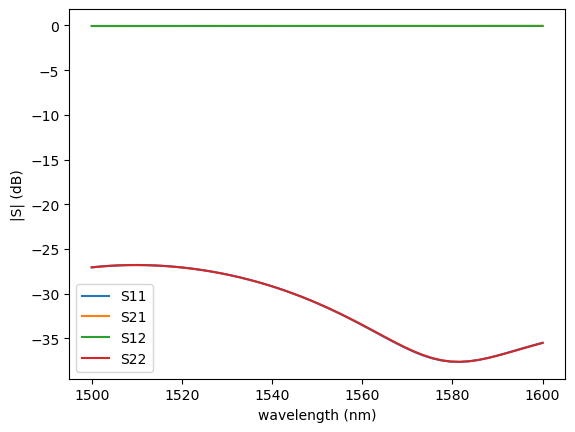

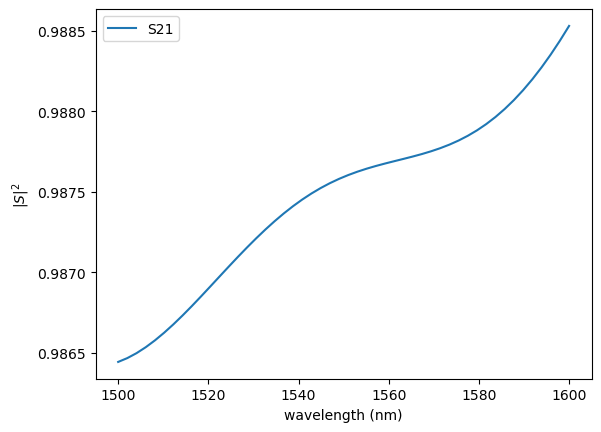

In [9]:
gplugins.plot.plot_sparameters(sp)
gplugins.plot.plot_sparameters(sp, keys=("o2@0,o1@0",), logscale=False)

2024-05-23 14:19:41.724 | WARNING  | gdsfactory.klive:show:49 - UserWarning: Could not connect to klive server. Is klayout open and klive plugin installed?


/home/doan/miniconda3/envs/mp/lib/python3.11/site-packages/gdsfactory/klive.py:49: UserWarning: Could not connect to klive server. Is klayout open and klive plugin installed?
  warnings.warn(


2024-05-23 14:19:41.743 | WARNING  | meep:_get_epsilon_grid:4442 - ComplexWarning: Casting complex values to real discards the imaginary part


/home/doan/miniconda3/envs/mp/lib/python3.11/site-packages/meep/__init__.py:4442: ComplexWarning: Casting complex values to real discards the imaginary part
  return _meep._get_epsilon_grid(gobj_list, mlist, _default_material, _ensure_periodicity, gv, cell_size, cell_center, nx, xtics, ny, ytics, nz, ztics, grid_vals, frequency)


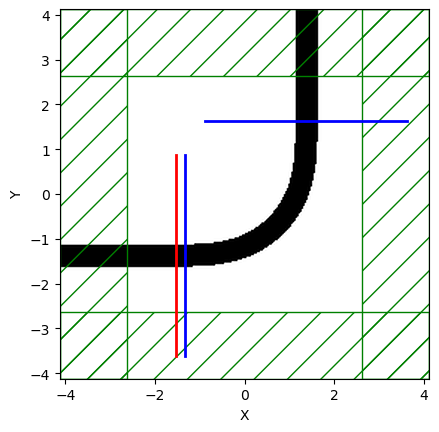

In [3]:
bend = gf.add_padding_container(
    bend,
    default=0,
    top=1,
    bottom=1,
    right = 1, 
    left = 1,
)
sim_dict = get_simulation(
    bend,
    is_3d=False,
    port_source_offset=-0.1,
    extend_ports_length=3,
    continuous_source=True,
    force_complex_fields=True,
    port_margin= 2,
)
sim = sim_dict["sim"]
sim.plot2D()
plt.show()

In [4]:
sim.init_sim()
sim.solve_cw(1e-6, 10000, 10)

2024-05-23 14:20:41.497 | WARNING  | meep:create_structure:4436 - ComplexWarning: Casting complex values to real discards the imaginary part
2024-05-23 14:20:41.501 | WARNING  | meep:_set_materials:4439 - ComplexWarning: Casting complex values to real discards the imaginary part


/home/doan/miniconda3/envs/mp/lib/python3.11/site-packages/meep/__init__.py:4436: ComplexWarning: Casting complex values to real discards the imaginary part
  return _meep.create_structure(cell_size, dft_data_list_, pml_1d_vols_, pml_2d_vols_, pml_3d_vols_, absorber_vols_, gv, br, sym, num_chunks, Courant, use_anisotropic_averaging, tol, maxeval, gobj_list, center, _ensure_periodicity, _default_material, alist, extra_materials, split_chunks_evenly, set_materials, existing_s, output_chunk_costs, my_bp)
/home/doan/miniconda3/envs/mp/lib/python3.11/site-packages/meep/__init__.py:4439: ComplexWarning: Casting complex values to real discards the imaginary part
  return _meep._set_materials(s, cell_size, gv, use_anisotropic_averaging, tol, maxeval, gobj_list, center, _ensure_periodicity, _default_material, alist, extra_materials, split_chunks_evenly, set_materials, existing_geps, output_chunk_costs, my_bp)


True

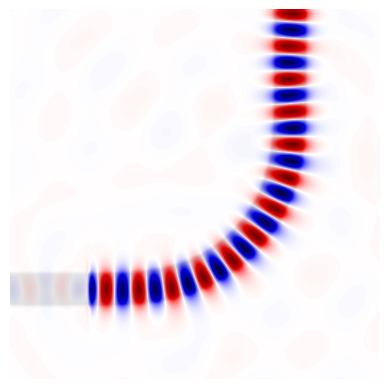

In [12]:
sx = sim.cell_size.x
sy = sim.cell_size.y
dpml = sim.boundary_layers[0].thickness
nonpml_vol = mp.Volume(mp.Vector3(), size=mp.Vector3(sx - 2 * dpml, sy - 2 * dpml))
ez_dat = sim.get_array(vol=nonpml_vol, component=mp.Ez)
eps_data = sim.get_array(vol=nonpml_vol, component=mp.Dielectric)
ez_data = np.real(ez_dat)

plt.figure()
plt.imshow(np.flipud(eps_data.transpose()), interpolation="spline36", cmap="binary")
plt.imshow(np.flipud(ez_data.transpose()), interpolation="spline36", cmap="seismic", alpha=0.9)
plt.axis("off")
plt.show()

2024-05-23 20:48:01.645 | INFO     | gdsfactory.technology.layer_views:to_lyp:1018 - LayerViews written to '/tmp/gdsfactory/mmi1x2.lyp'.


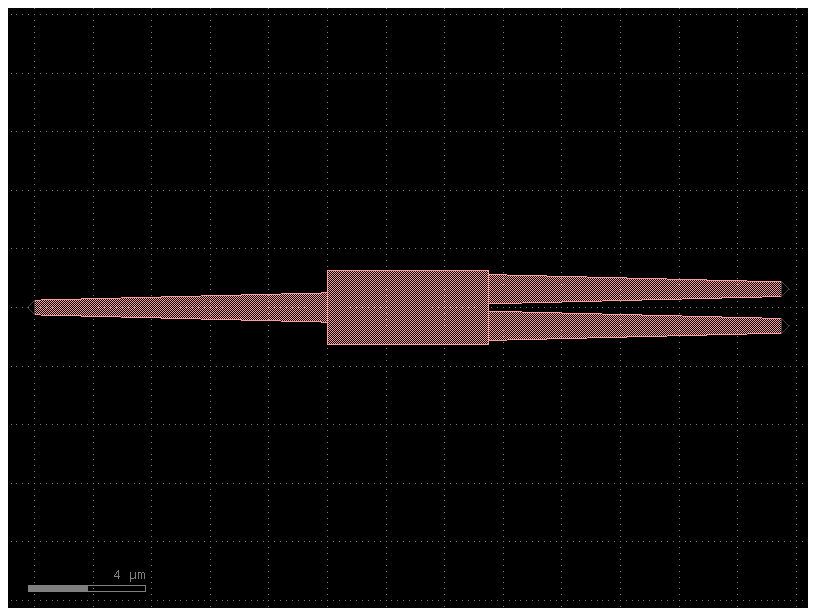

In [4]:
mmi = gf.components.mmi1x2()
mmi.plot()

In [ ]:
sm = gt.write_sparameters(
    mmi, 
    layer_stack=LAYER_STACK, 
    filepath= "data/mmi_td.npz", 
    sim_size_z=4)

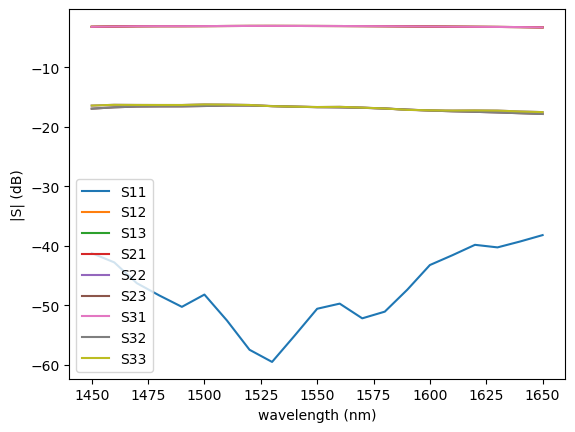

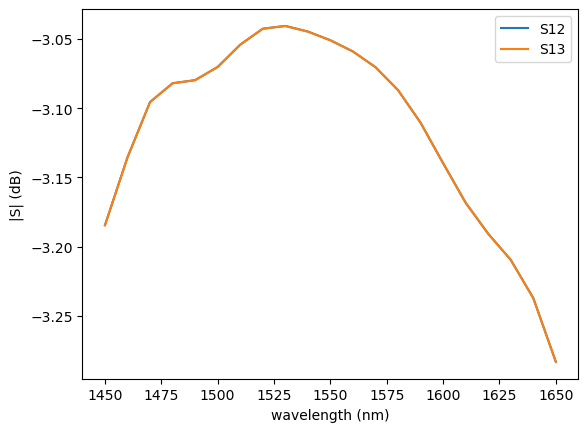

In [3]:
sk = np.load("data/mmi_td.npz")
plot.plot_sparameters(sk)
plot.plot_sparameters(sk, keys=("o1@0,o2@0", "o1@0,o3@0"))

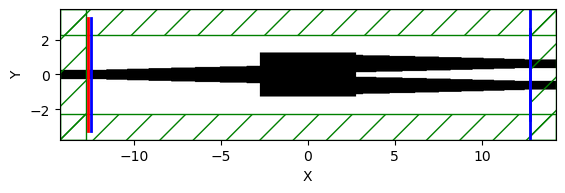

In [7]:
mmi = gf.add_padding_container(
    mmi,
    default=0,
    top=1,
    bottom=1,
)
sim_dict = get_simulation(
    mmi,
    is_3d=False,
    port_source_offset=-0.1,
    extend_ports_length=3,
    continuous_source=True,
    force_complex_fields=True,
)
sim = sim_dict["sim"]
sim.plot2D()
plt.show()

In [8]:
sim.init_sim()
sim.solve_cw(1e-6, 10000, 10)

2024-05-23 20:52:19.927 | WARNING  | meep:create_structure:4436 - ComplexWarning: Casting complex values to real discards the imaginary part
2024-05-23 20:52:19.930 | WARNING  | meep:_set_materials:4439 - ComplexWarning: Casting complex values to real discards the imaginary part


/home/doan/miniconda3/envs/mp/lib/python3.11/site-packages/meep/__init__.py:4436: ComplexWarning: Casting complex values to real discards the imaginary part
  return _meep.create_structure(cell_size, dft_data_list_, pml_1d_vols_, pml_2d_vols_, pml_3d_vols_, absorber_vols_, gv, br, sym, num_chunks, Courant, use_anisotropic_averaging, tol, maxeval, gobj_list, center, _ensure_periodicity, _default_material, alist, extra_materials, split_chunks_evenly, set_materials, existing_s, output_chunk_costs, my_bp)
/home/doan/miniconda3/envs/mp/lib/python3.11/site-packages/meep/__init__.py:4439: ComplexWarning: Casting complex values to real discards the imaginary part
  return _meep._set_materials(s, cell_size, gv, use_anisotropic_averaging, tol, maxeval, gobj_list, center, _ensure_periodicity, _default_material, alist, extra_materials, split_chunks_evenly, set_materials, existing_geps, output_chunk_costs, my_bp)


True

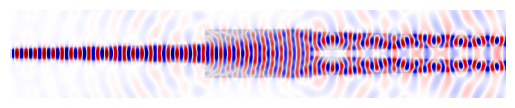

In [9]:
sx = sim.cell_size.x
sy = sim.cell_size.y
dpml = sim.boundary_layers[0].thickness
nonpml_vol = mp.Volume(mp.Vector3(), size=mp.Vector3(sx - 2 * dpml, sy - 2 * dpml))
ez_dat = sim.get_array(vol=nonpml_vol, component=mp.Ez)
eps_data = sim.get_array(vol=nonpml_vol, component=mp.Dielectric)
ez_data = np.real(ez_dat)

plt.figure()
plt.imshow(eps_data.transpose(), interpolation="spline36", cmap="binary")
plt.imshow(ez_data.transpose(), interpolation="spline36", cmap="seismic", alpha=0.9)
plt.axis("off")
plt.show()

2024-05-24 11:35:03.531 | INFO     | gdsfactory.technology.layer_views:to_lyp:1018 - LayerViews written to '/tmp/gdsfactory/mzi_delta_length25.lyp'.


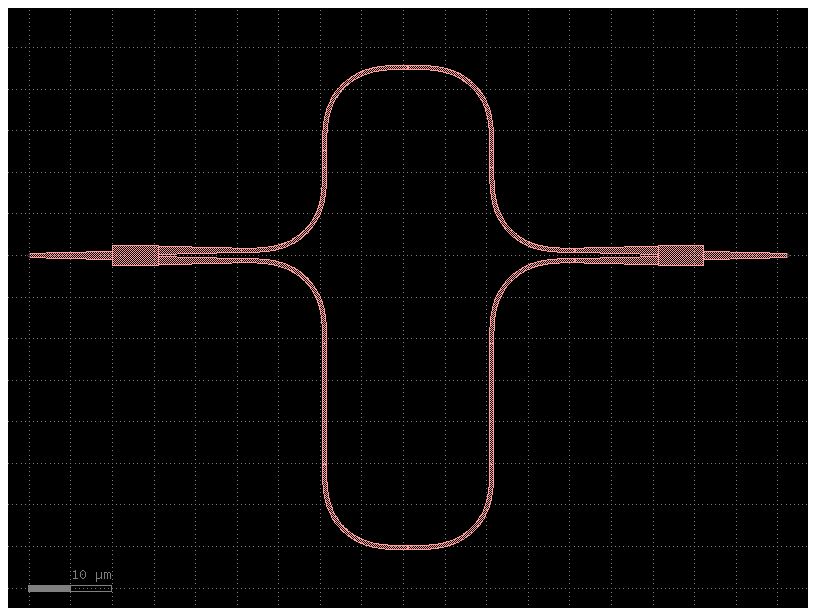

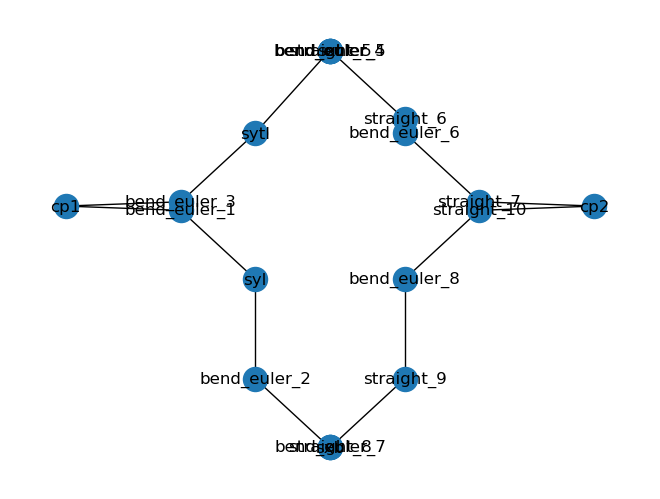

In [10]:
delta_length = 25
mzi_component = gf.components.mzi(delta_length=delta_length)
mzi_component.plot()
mzi_component.plot_netlist()

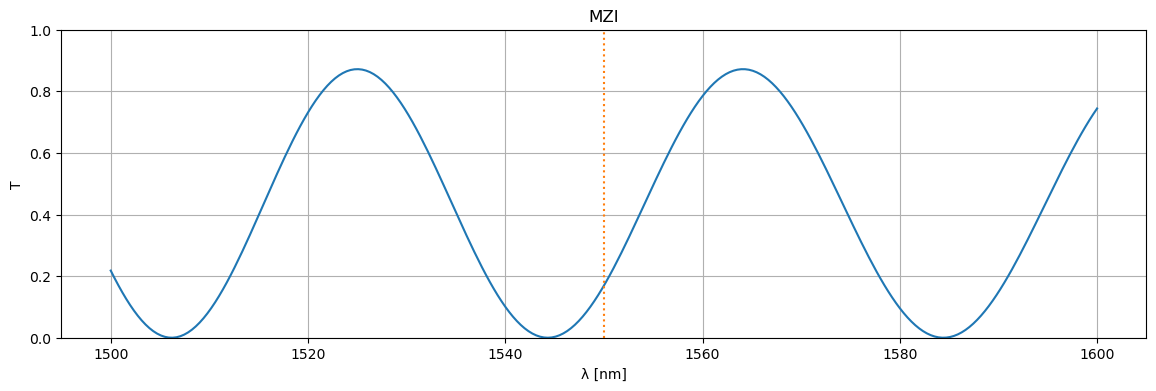

In [11]:
def straight(wl=1.5, length=10.0, neff=2.44) -> sax.SDict:
    return sax.reciprocal({("o1", "o2"): jnp.exp(2j * jnp.pi * neff * length / wl)})


def mmi1x2():
    return sax.reciprocal(
        {
            ("o1", "o2"): 0.49**0.5,
            ("o1", "o3"): 0.49**0.5,
        }
    )


def bend_euler(wl=1.5, length=20.0):
    """ "Let's assume a reduced transmission for the euler bend compared to a straight"""
    return {k: 0.988 * v for k, v in straight(wl=wl, length=length).items()}


models = {
    "bend_euler": bend_euler,
    "mmi1x2": mmi1x2,
    "straight": straight,
}

mzi_circuit, _ = sax.circuit(netlist=mzi_component.get_netlist(), models=models)
S = mzi_circuit(wl=1.55)
wl = np.linspace(1.5, 1.6, 256)
S = mzi_circuit(wl=wl)

plt.figure(figsize=(14, 4))
plt.title("MZI")
plt.plot(1e3 * wl, jnp.abs(S["o1", "o2"]) ** 2)
plt.plot([1550, 1550], [0, 1], linestyle = "dotted")
plt.ylim([0, 1])
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.grid(True)
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

9.846123418433722


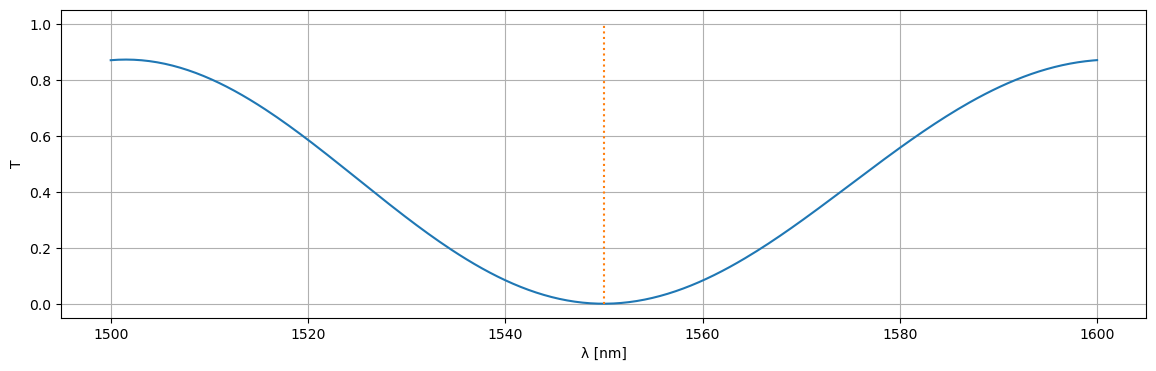

In [12]:
@jax.jit
def loss_fn(delta_length):
    S = mzi_circuit(
        wl=1.55,
        syl={
            "length": delta_length / 2 + 2,
        },
        straight_9={
            "length": delta_length / 2 + 2,
        },
    )
    T = abs(S["o1", "o2"]) ** 2
    # return (abs(S["o1", "o2"]) ** 2).mean()
    return T.mean()


grad_fn = jax.jit(
    jax.grad(
        loss_fn,
        argnums=0,  # JAX gradient function for the first positional argument, jitted
    )
)

initial_delta_length = 10.0
init_fn, update_fn, params_fn = opt.adam(step_size=0.01)
state = init_fn(initial_delta_length)

def step_fn(step, state):
    settings = params_fn(state)
    loss = loss_fn(settings)
    grad = grad_fn(settings)
    state = update_fn(step, grad, state)
    return loss, state

range_ = trange(100)
for step in range_:
    loss, state = step_fn(step, state)
    range_.set_postfix(loss=f"{loss:.6f}")

delta_length = params_fn(state)
print(delta_length)

S = mzi_circuit(
    wl=wl,
    syl={"length": delta_length / 2 + 2},
    straight_9={"length": delta_length / 2 + 2},
)
plt.figure(figsize=(14, 4))
plt.plot(wl * 1e3, abs(S["o1", "o2"]) ** 2)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.ylim(-0.05, 1.05)
plt.plot([1550, 1550], [0, 1], linestyle = "dotted")
plt.grid(True)
plt.show()

2024-05-24 11:36:11.323 | INFO     | gdsfactory.technology.layer_views:to_lyp:1018 - LayerViews written to '/tmp/gdsfactory/mzis.lyp'.


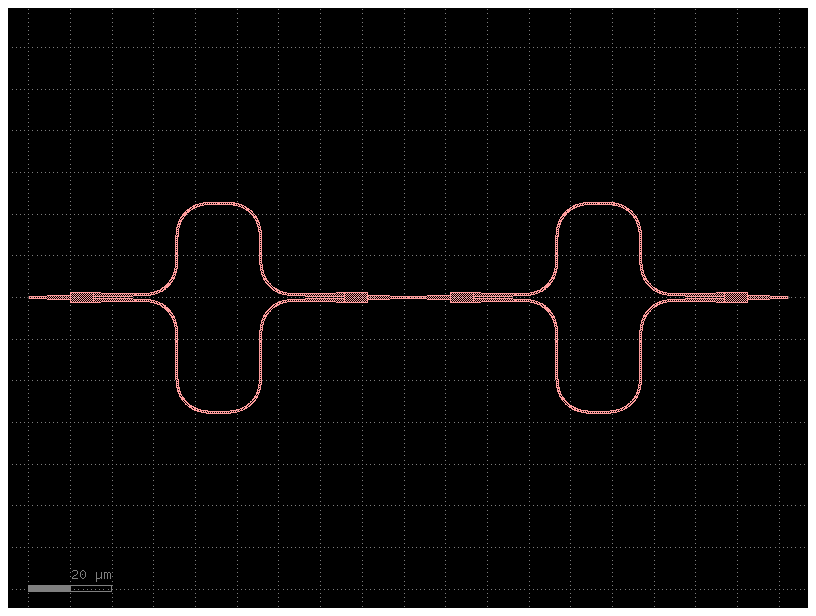

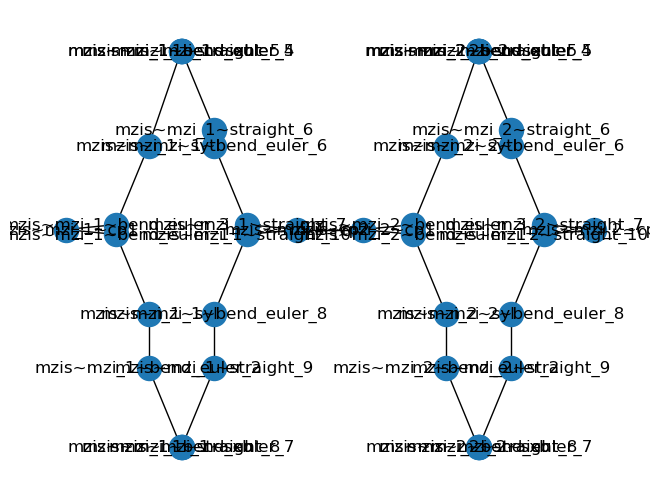

In [13]:
@gf.cell
def mzis(delta_length = 9.85):
    c = gf.Component()
    c1 = c << gf.components.mzi(delta_length = delta_length)
    c2 = c << gf.components.mzi(delta_length = delta_length)
    c2.connect("o1", c1.ports["o2"])

    c.add_port("o1", port = c1.ports["o1"])
    c.add_port("o2", port = c2.ports["o2"])
    return c

c1 = mzis()
c1.plot()
c1.plot_netlist_flat()

2024-05-24 11:36:21.993 | INFO     | gdsfactory.technology.layer_views:to_lyp:1018 - LayerViews written to '/tmp/gdsfactory/mzip.lyp'.


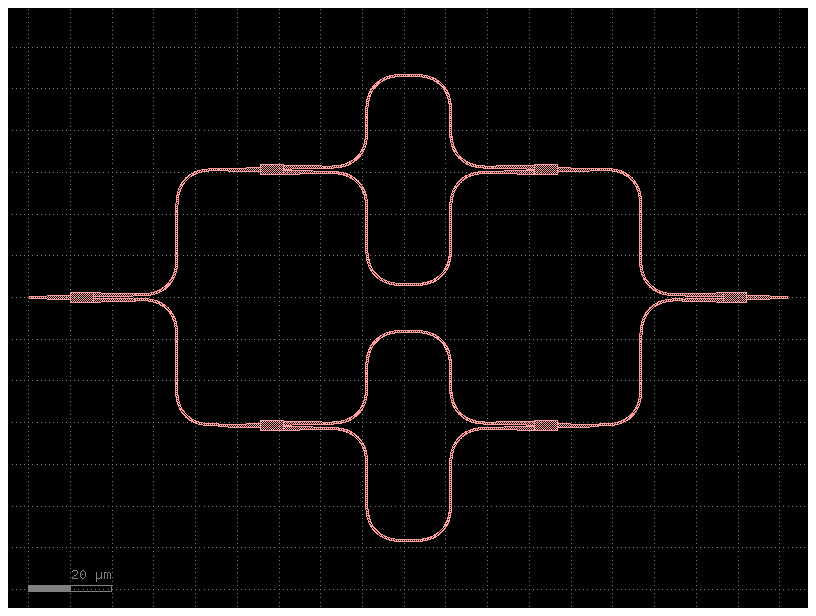

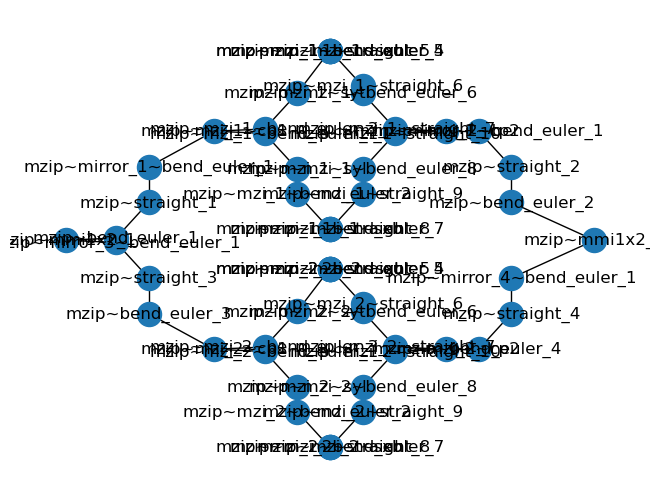

In [14]:
@gf.cell
def mzip(delta_length = 9.85):
    c = gf.Component()
    c1 = c << gf.components.mzi(delta_length = delta_length)
    c2 = c << gf.components.mzi(delta_length = delta_length)
    mmi_in = c << gf.components.mmi1x2()
    mmi_out = c << gf.components.mmi1x2()

    bend_top_1 = c << gf.components.bend_euler()
    straight_top_1 = c << gf.components.straight(length=10)
    bend_top_2 = c << (gf.components.bend_euler()).mirror()

    bend_top_3 = c << (gf.components.bend_euler()).mirror()
    straight_top_2 = c << gf.components.straight(length=10)
    bend_top_4 = c << gf.components.bend_euler()
    
    bend_bot_1 = c << (gf.components.bend_euler()).mirror()
    straight_bot_1 = c << gf.components.straight(length=10)
    bend_bot_2 = c << (gf.components.bend_euler())

    bend_bot_3 = c << (gf.components.bend_euler())
    straight_bot_2 = c << gf.components.straight(length=10)
    bend_bot_4 = c << (gf.components.bend_euler()).mirror()

    # connections
    bend_top_1.connect("o1", mmi_in.ports["o2"])
    straight_top_1.connect("o1", bend_top_1.ports["o2"])
    bend_top_2.connect("o1", straight_top_1.ports["o2"])
    c1.connect("o1", bend_top_2.ports["o2"])
    bend_top_3.connect("o1", c1.ports["o2"])
    straight_top_2.connect("o1", bend_top_3.ports["o2"])
    bend_top_4.connect("o1", straight_top_2.ports["o2"])
    mmi_out.connect("o3", bend_top_4.ports["o2"])

    bend_bot_1.connect("o1", mmi_in.ports["o3"])
    straight_bot_1.connect("o1", bend_bot_1.ports["o2"])
    bend_bot_2.connect("o1", straight_bot_1.ports["o2"])
    c2.connect("o1", bend_bot_2.ports["o2"])
    bend_bot_3.connect("o1", c2.ports["o2"])
    straight_bot_2.connect("o1", bend_bot_3.ports["o2"])
    bend_bot_4.connect("o1", straight_bot_2.ports["o2"])
    mmi_out.connect("o2", bend_bot_4.ports["o2"])


    c.add_port("o1", port = mmi_in.ports["o1"])
    c.add_port("o2", port = mmi_out.ports["o1"])
    return c

c2 = mzip()
c2.plot()
c2.plot_netlist_flat()

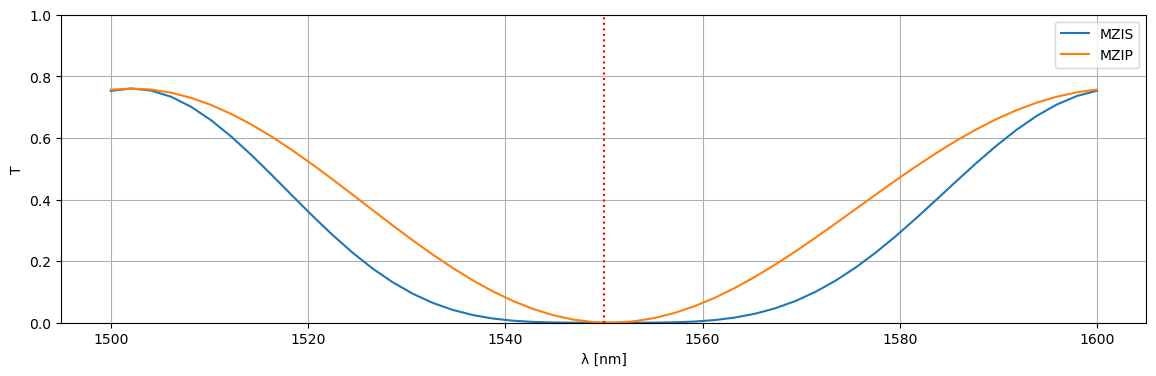

In [18]:
wl = np.linspace(1.5, 1.6)
netlist1 = c1.get_netlist_recursive()
circuit1, _ = sax.circuit(netlist=netlist1, models=models)
S1 = circuit1(wl=wl)

netlist2 = c2.get_netlist_recursive()
circuit2, _ = sax.circuit(netlist=netlist2, models=models)
S2 = circuit2(wl=wl)

plt.figure(figsize=(14, 4))
plt.plot(1e3 * wl, jnp.abs(S1["o1", "o2"]) ** 2, label="MZIS")
plt.plot(1e3 * wl, jnp.abs(S2["o1", "o2"]) ** 2, label="MZIP")
plt.plot([1550, 1550], [0, 1], linestyle = "dotted", color = 'r')
plt.ylim([0, 1])
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.grid(True)
plt.legend()
plt.show()